In [0]:
import numpy as np
import torch
import time
import copy
import sys

class NeuralNetwork_Convolutional():
    
    def __init__(self, n_channels_in_image, image_size,
                 n_units_in_conv_layers, kernels_size_and_stride,
                 n_units_in_fc_hidden_layers,
                 classes, use_gpu=False):

        if not isinstance(n_units_in_conv_layers, list):
            raise Exception('n_units_in_conv_layers must be a list')

        if not isinstance(n_units_in_fc_hidden_layers, list):
            raise Exception('n_units_in_fc_hidden_layers must be a list')
        
        if use_gpu and not torch.cuda.is_available():
            print('\nGPU is not available. Running on CPU.\n')
            use_gpu = False

        self.n_channels_in_image = n_channels_in_image
        self.image_size = image_size 
        self.n_units_in_conv_layers = n_units_in_conv_layers
        self.n_units_in_fc_hidden_layers = n_units_in_fc_hidden_layers
        self.kernels_size_and_stride = kernels_size_and_stride
        self.n_outputs = len(classes)
        self.classes = np.array(classes)
        self.use_gpu = use_gpu
        
        self.n_conv_layers = len(self.n_units_in_conv_layers)
        self.n_fc_hidden_layers = len(self.n_units_in_fc_hidden_layers)

        # Build the net layers
        self.nnet = torch.nn.Sequential()
        self.training_time=0
        # Add convolutional layers

        n_units_previous = self.n_channels_in_image
        output_size_previous = self.image_size
        n_layers = 0
        if self.n_conv_layers > 0:

            for (n_units, kernel) in zip(self.n_units_in_conv_layers, self.kernels_size_and_stride):
                n_units_previous, output_size_previous = self._add_conv2d_tanh(n_layers,
                                        n_units_previous, output_size_previous, n_units, kernel)
                n_layers += 1 # for text label in layer
                
        # A4.3 version moved following statement left one indent level
        
        self.nnet.add_module('flatten', torch.nn.Flatten())  # prepare for fc layers

        n_inputs = output_size_previous ** 2 * n_units_previous
        if self.n_fc_hidden_layers > 0:
            for n_units in self.n_units_in_fc_hidden_layers:
                n_inputs = self._add_fc_tanh(n_layers, n_inputs, n_units)
                n_layers += 1

        self.nnet.add_module(f'output_{n_layers}', torch.nn.Linear(n_inputs, self.n_outputs))

        # Member variables for standardization
        self.Xmeans = None
        self.Xstds = None

        if self.use_gpu:
            self.nnet.cuda()

        self.n_epochs = 0
        self.error_trace = []

    def _add_conv2d_tanh(self, n_layers, n_units_previous, output_size_previous,
                   n_units, kernel_size_and_stride):
        kernel_size, kernel_stride = kernel_size_and_stride
        self.nnet.add_module(f'conv_{n_layers}', torch.nn.Conv2d(n_units_previous, n_units,
                                                                 kernel_size, kernel_stride))
        self.nnet.add_module(f'output_{n_layers}', torch.nn.Tanh())
        output_size_previous = (output_size_previous - kernel_size) // kernel_stride + 1
        n_units_previous = n_units                
        return n_units_previous, output_size_previous
    
    def _add_fc_tanh(self, n_layers, n_inputs, n_units):
        self.nnet.add_module(f'linear_{n_layers}', torch.nn.Linear(n_inputs, n_units))
        self.nnet.add_module(f'output_{n_layers}', torch.nn.Tanh())
        n_inputs = n_units
        return n_inputs

    def __repr__(self):
        str = f'''{type(self).__name__}(
                            n_channels_in_image={self.n_channels_in_image},
                            image_size={self.image_size},
                            n_units_in_conv_layers={self.n_units_in_conv_layers},
                            kernels_size_and_stride={self.kernels_size_and_stride},
                            n_units_in_fc_hidden_layers={self.n_units_in_fc_hidden_layers},
                            classes={self.classes},
                            use_gpu={self.use_gpu})'''

        str += self.nnet
        if self.n_epochs > 0:
            str += f'\n   Network was trained for {self.n_epochs} epochs that took {self.training_time:.4f} seconds.'
            str += f'\n   Final objective value is {self.error_trace[-1]:.3f}'
        else:
            str += '  Network is not trained.'
        return str
        
    def _standardizeX(self, X):
        result = (X - self.Xmeans) / self.XstdsFixed
        result[:, self.Xconstant] = 0.0
        return result

    def _unstandardizeX(self, Xs):
        return self.Xstds * Xs + self.Xmeans

    def _setup_standardize(self, X, T):
        if self.Xmeans is None:
            self.Xmeans = X.mean(axis=0)
            self.Xstds = X.std(axis=0)
            self.Xconstant = self.Xstds == 0
            self.XstdsFixed = copy.copy(self.Xstds)
            self.XstdsFixed[self.Xconstant] = 1

    def train(self, X, T, n_epochs, learning_rate=0.01):

        start_time = time.time()
        
        self.learning_rate = learning_rate

        if T.ndim == 1:
            T = T.reshape((-1, 1))

        _, T = np.where(T == self.classes)  # convert to labels from 0

        self._setup_standardize(X, T)
        X = self._standardizeX(X)

        X = torch.tensor(X)
        T = torch.tensor(T.reshape(-1))
        if self.use_gpu:
            X = X.cuda()
            T = T.cuda()

            
        #    You fill in the rest of the train function, following lecture notes example.
        #    .
        #  
        optimizer = torch.optim.Adam(self.nnet.parameters(), lr=learning_rate)
        loss_F = torch.nn.CrossEntropyLoss()
        for epoch in range(n_epochs):
    
          optimizer.zero_grad()
        
          Y = self.nnet(X)
    
          error = loss_F(Y, T)
          if epoch % 50 == 0:
              print(f'Epoch {epoch} error {error}')
                      
          self.error_trace.append(error)
          error.backward()
          
          optimizer.step()
        stop_time=time.time()
        self.training_time=stop_time-start_time
        
    def get_error_trace(self):
        return self.error_trace
    
    def _softmax(self, Y):
        mx = Y.max()
        expY = np.exp(Y - mx)
        denom = expY.sum(axis=1).reshape((-1, 1)) + sys.float_info.epsilon
        return expY / denom
    
    def use(self, X):
        self.nnet.eval()  # turn off gradients and other aspects of training
        X = self._standardizeX(X)
        X = torch.tensor(X)
        if self.use_gpu:
            X = X.cuda()

        Y = self.nnet(X)

        if self.use_gpu:
            Y = Y.cpu()
        Y = Y.detach().numpy()
        Yclasses = self.classes[Y.argmax(axis=1)].reshape((-1, 1))

        return Yclasses, self._softmax(Y)

## Simple Example with Squares and Diamonds

Repeating the example from lecture notes.

In [0]:
import matplotlib.pyplot as plt

In [0]:
def make_images(nEach):
    images = np.zeros((nEach * 2, 1, 20, 20))  # nSamples, nChannels, rows, columns
    radii = 3 + np.random.randint(10 - 5, size=(nEach * 2, 1))
    centers = np.zeros((nEach * 2, 2))
    for i in range(nEach * 2):
        r = radii[i, 0]
        centers[i, :] = r + 1 + np.random.randint(18 - 2 * r, size=(1, 2))
        x = int(centers[i, 0])
        y = int(centers[i, 1])
        if i < nEach:
            # squares
            images[i, 0, x - r:x + r, y + r] = 1.0
            images[i, 0, x - r:x + r, y - r] = 1.0
            images[i, 0, x - r, y - r:y + r] = 1.0
            images[i, 0, x + r, y - r:y + r + 1] = 1.0
        else:
            # diamonds
            images[i, 0, range(x - r, x), range(y, y + r)] = 1.0
            images[i, 0, range(x - r, x), range(y, y - r, -1)] = 1.0
            images[i, 0, range(x, x + r + 1), range(y + r, y - 1, -1)] = 1.0
            images[i, 0, range(x, x + r), range(y - r, y)] = 1.0
            # images += np.random.randn(*images.shape) * 0.5
            T = np.ones((nEach * 2, 1))
            T[nEach:] = 2
    return images.astype(np.float32), T.astype(np.int)

Xtrain, Ttrain = make_images(500)
Xtest, Ttest = make_images(10)

Xtrain.shape, Ttrain.shape, Xtest.shape, Ttest.shape

((1000, 1, 20, 20), (1000, 1), (20, 1, 20, 20), (20, 1))

In [0]:
nnet = NeuralNetwork_Convolutional(n_channels_in_image=Xtrain.shape[1],
                                   image_size=Xtrain.shape[2],
                                   n_units_in_conv_layers=[5],
                                   kernels_size_and_stride=[[3,2]],# , 5],
                                   n_units_in_fc_hidden_layers=[2], # 10, 10],
                                   classes=[1, 2],
                                   use_gpu=True)

nnet.train(Xtrain, Ttrain, 100, learning_rate=0.01)

Epoch 0 error 0.6857492923736572
Epoch 50 error 0.10350113362073898


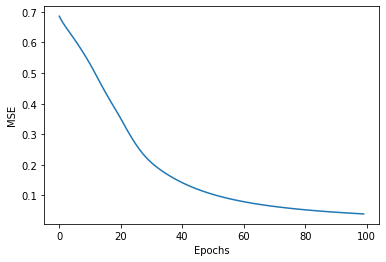

In [0]:
plt.plot(nnet.get_error_trace())
plt.xlabel('Epochs')
plt.ylabel('MSE');

In [0]:
Yclasses, Y = nnet.use(Xtest)

print(f'{np.sum(Ttest == Yclasses)} out of {Ttest.shape[0]} test samples correctly classified.', end='')
print(f'  Training took {nnet.training_time:.3f} seconds.')

20 out of 20 test samples correctly classified.  Training took 0.363 seconds.


Let's see what the output of the convolutional layer produces, and the weight matrices of each unit that produce those output images.   Here are functions, `show_layer_output` and `show_layer_weights` that will do this for us.

In [0]:
import matplotlib.pyplot as plt

def show_layer_output(nnet, X_sample, layer):
    outputs = []
    reg = nnet.nnet[layer * 2].register_forward_hook(
        lambda self, i, o: outputs.append(o))
    nnet.use(X_sample)
    reg.remove()
    output = outputs[0]

    n_units = output.shape[1]
    nplots = int(np.sqrt(n_units)) + 1
    for unit in range(n_units):
        plt.subplot(nplots, nplots, unit+1)
        plt.imshow(output[0, unit, :, :].detach().cpu(),cmap='binary')
        plt.axis('off')
    return output

def show_layer_weights(nnet, layer):
    W = nnet.nnet[layer*2].weight.detach()
    n_units = W.shape[0]
    nplots = int(np.sqrt(n_units)) + 1
    for unit in range(n_units):
        plt.subplot(nplots, nplots, unit + 1)
        plt.imshow(W[unit, 0, :, :].detach().cpu(), cmap='binary')
        plt.axis('off')
    return W

(-0.5, 19.5, 19.5, -0.5)

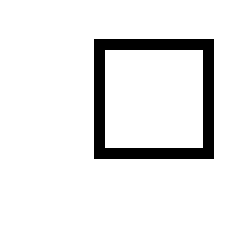

In [0]:
X_sample = Xtest[0:1, :, :, :]
plt.imshow(X_sample[0, 0, :, :], cmap='binary')
plt.axis('off')

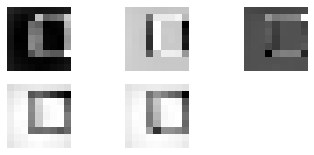

In [0]:
show_layer_output(nnet, X_sample, 0);

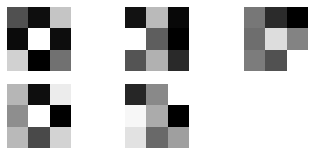

In [0]:
show_layer_weights(nnet, 0);

## MNIST Digits

Investigate the application of your code to the classification of MNIST digits, which you may download from [this site](http://deeplearning.net/tutorial/gettingstarted.html).

In [0]:
import numpy as np
import matplotlib.pyplot as plt
import pickle, gzip

# Load the dataset
with gzip.open('mnist.pkl.gz', 'rb') as f:
    train_set, valid_set, test_set = pickle.load(f, encoding='latin1')

In [0]:
Xtrain = train_set[0]
Ttrain = train_set[1]
Xtrain.shape, Ttrain.shape

((50000, 784), (50000,))

In [0]:
Xtest = test_set[0]
Ttest = test_set[1]
Xtest.shape, Ttest.shape


((10000, 784), (10000,))

In [0]:
XV=valid_set[0]
TV=valid_set[1]
XV.shape,TV.shape

((10000, 784), (10000,))

In [0]:
def make_images1(nEach,Xtrain):
    images = np.zeros((nEach * 2, 1, 28, 28))  # nSamples, nChannels, rows, columns
    for i in range(nEach*2-1):
      #print(i)
      #print(Xtrain[i,:].shape)
      a = Xtrain[i, :].reshape(28, 28)
      #a.shape
      images[i,0,0:28,0:28]=a[0:28,0:28]
    return images
    """""for i in range(nEach * 2):
        r = radii[i, 0]
        centers[i, :] = r + 1 + np.random.randint(18 - 2 * r, size=(1, 2))
        x = int(centers[i, 0])
        y = int(centers[i, 1])
        if i < nEach:
            # squares
            images[i, 0, x - r:x + r, y + r] = 1.0
            images[i, 0, x - r:x + r, y - r] = 1.0
            images[i, 0, x - r, y - r:y + r] = 1.0
            images[i, 0, x + r, y - r:y + r + 1] = 1.0
        else:
            # diamonds
            images[i, 0, range(x - r, x), range(y, y + r)] = 1.0
            images[i, 0, range(x - r, x), range(y, y - r, -1)] = 1.0
            images[i, 0, range(x, x + r + 1), range(y + r, y - 1, -1)] = 1.0
            images[i, 0, range(x, x + r), range(y - r, y)] = 1.0
            # images += np.random.randn(*images.shape) * 0.5
            T = np.ones((nEach * 2, 1))
            T[nEach:] = 2
    return images.astype(np.float32), T.astype(np.int)

Xtrain, Ttrain = make_images(500)
Xtest, Ttest = make_images(10)

Xtrain.shape, Ttrain.shape, Xtest.shape, Ttest.shape"""

In [0]:
P=np.unique(Ttrain)

In [0]:
a = Xtrain[0, :].reshape(28, 28)
a.shape

(28, 28)

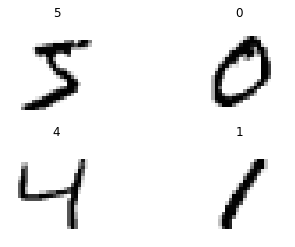

In [0]:
for i in range(4):
    plt.subplot(2, 2, i + 1)
    plt.imshow(Xtrain[i, :].reshape(28,28), cmap='binary')
    plt.title(Ttrain[i])
    plt.axis('off');

**Case 1**-Now we will first test the model with 5 units in  1 convolutional layer  with a kernel size of 3*3  and a stride of 2 

In [0]:
nnet = NeuralNetwork_Convolutional(n_channels_in_image=1,
                                   image_size=28,
                                   n_units_in_conv_layers=[5],
                                   kernels_size_and_stride=[[3,2]],# , 5],
                                   n_units_in_fc_hidden_layers=[2], # 10, 10],
                                   classes=P,
                                   use_gpu=True)

Xtrain1=make_images1(25000,Xtrain)

Xtrain1=torch.tensor(Xtrain1).to('cuda')
Xtrain1=Xtrain1.float()
nnet.train(Xtrain1, Ttrain, 200, learning_rate=0.01)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:137: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch 0 error 2.414691925048828
Epoch 50 error 1.5708140134811401
Epoch 100 error 1.361205816268921
Epoch 150 error 1.241809368133545


In [0]:
Xtest1=make_images1(5000,Xtest)

Xtest1=torch.tensor(Xtest1).to('cuda')
Xtest1=Xtest1.float()
Yclasses, Y = nnet.use(Xtest1)
Ttest=np.array(Ttest).reshape(10000,1)
print(f'{np.sum(Ttest == Yclasses)} out of {Ttest.shape[0]} test samples correctly classified.')
a=np.sum(Ttest == Yclasses)/Ttest.shape[0]
print(f'Accuracy is  {a}')
print(f'  Training took {nnet.training_time:.3f} seconds.')

4611 out of 10000 test samples correctly classified.
Accuracy is  0.4611
  Training took 22.364 seconds.


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:178: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


In [0]:
XV=make_images1(5000,XV)

XV=torch.tensor(XV).to('cuda')
XV=XV.float()

So accuracy is quite bad i.e. 46.11% .

**Case 2**

Now finding the number of  layers for which the accuracy will improve . I have done a for loop for the values of the number  of the layers with only one unit in each layer. We will take the number of layers for which the accuracy will be highest or for which the increase in accuracy is not as much with respect to training time. The kernel size is taken to be 1*1 with a stride of 1.The number of epochs is taken to be 100

In [0]:
[[2,1] for i in range(3)]

[[2, 1], [2, 1], [2, 1]]

In [0]:
li=[]

for i in range(1,11):
  li.append(2)
  kernel=[[2,1]for j in range(i)]
  print(li)
  print(kernel)
  nnet = NeuralNetwork_Convolutional(n_channels_in_image=1,
                                   image_size=28,
                                   n_units_in_conv_layers=li,
                                   kernels_size_and_stride=kernel,# , 5],
                                   n_units_in_fc_hidden_layers=[3], # 10, 10],
                                   classes=P,
                                   use_gpu=True)

  Xtrain1=make_images1(25000,Xtrain)

  Xtrain1=torch.tensor(Xtrain1).to('cuda')
  Xtrain1=Xtrain1.float()
  nnet.train(Xtrain1, Ttrain, 100, learning_rate=0.01)
  Xtest1=make_images1(5000,Xtest)

  Xtest1=torch.tensor(Xtest1).to('cuda')
  Xtest1=Xtest1.float()
  Yclasses, Y = nnet.use(Xtest1)
  Ttest=np.array(Ttest).reshape(10000,1)
  print()
  print()
  print(f'So for {i} conv layers results are')
  print(f'{np.sum(Ttest == Yclasses)} out of {Ttest.shape[0]} test samples correctly classified.')
  a=np.sum(Ttest == Yclasses)/Ttest.shape[0]*100
  print(f'Accuracy of test data   is  {a}%')
  
  
  Yclasses1, Y1 = nnet.use(Xtrain1)
  Ttrain=np.array(Ttrain).reshape(50000,1)
  print(f'{np.sum(Ttrain == Yclasses1)} out of {Ttrain.shape[0]} test samples correctly classified.')
  a1=np.sum(Ttrain == Yclasses1)/Ttrain.shape[0]*100
  print(f'Accuracy of train data   is  {a1}%')
  
  Yclasses2, Y2 = nnet.use(XV)
  TV=np.array(TV).reshape(10000,1)
  print(f'{np.sum(TV == Yclasses2)} out of {TV.shape[0]} test samples correctly classified.')
  a2=np.sum(TV == Yclasses2)/TV.shape[0]*100
  print(f'Accuracy of validation data   is  {a2}%')
  print(f'Training  took {nnet.training_time:.3f} seconds.')
  print()
  print()
  

[2]
[[2, 1]]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:137: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch 0 error 2.3496551513671875
Epoch 50 error 1.3466198444366455


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:178: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).




So for 1 conv layers results are
6503 out of 10000 test samples correctly classified.
Accuracy of test data   is  65.03%
32921 out of 50000 test samples correctly classified.
Accuracy of train data   is  65.842%
6662 out of 10000 test samples correctly classified.
Accuracy of validation data   is  66.62%
Training  took 29.225 seconds.


[2, 2]
[[2, 1], [2, 1]]
Epoch 0 error 2.3442916870117188
Epoch 50 error 1.3107362985610962


So for 2 conv layers results are
5945 out of 10000 test samples correctly classified.
Accuracy of test data   is  59.45%
29772 out of 50000 test samples correctly classified.
Accuracy of train data   is  59.544%
5946 out of 10000 test samples correctly classified.
Accuracy of validation data   is  59.46%
Training  took 62.357 seconds.


[2, 2, 2]
[[2, 1], [2, 1], [2, 1]]
Epoch 0 error 2.3383781909942627
Epoch 50 error 1.342264175415039


So for 3 conv layers results are
6263 out of 10000 test samples correctly classified.
Accuracy of test data   is  62.6299999

**Case 3**


So we see that the network works well for 1 and 2 convolutional layers as the traning is less and the accuracy is also good. Moreover the increase in number of layers may increase the accuracy but the training is also increased significantly so it is not efficient  to use mre than 2 layers. Now we will vary the units in each conv layer. So we will now test the number of units in 1 and 2 convolutional layers


First testing with 1 convolutional layer

So now testing with number of units in 1 convolutional layer.

In [0]:
for i in range(2,12):
  li=[]

  for j in range(1):
    li.append(i)
  print(li)
  kernel=[[2,1]for j in range(1)]
  print(kernel)
  nnet = NeuralNetwork_Convolutional(n_channels_in_image=1,
                                   image_size=28,
                                   n_units_in_conv_layers=li,
                                   kernels_size_and_stride=kernel,# , 5],
                                   n_units_in_fc_hidden_layers=[3], # 10, 10],
                                   classes=P,
                                   use_gpu=True)

  Xtrain1=make_images1(25000,Xtrain)

  Xtrain1=torch.tensor(Xtrain1).to('cuda')
  Xtrain1=Xtrain1.float()
  nnet.train(Xtrain1, Ttrain, 100, learning_rate=0.01)
  Xtest1=make_images1(5000,Xtest)

  Xtest1=torch.tensor(Xtest1).to('cuda')
  Xtest1=Xtest1.float()
  Yclasses, Y = nnet.use(Xtest1)
  Ttest=np.array(Ttest).reshape(10000,1)
  print()
  print()
  print(f'So for {i} units in 1  conv layers results are')
  print(f'{np.sum(Ttest == Yclasses)} out of {Ttest.shape[0]} test samples correctly classified.')
  a=np.sum(Ttest == Yclasses)/Ttest.shape[0]*100
  print(f'Accuracy of test data   is  {a}%')
  
  
  Yclasses1, Y1 = nnet.use(Xtrain1)
  Ttrain=np.array(Ttrain).reshape(50000,1)
  print(f'{np.sum(Ttrain == Yclasses1)} out of {Ttrain.shape[0]} test samples correctly classified.')
  a1=np.sum(Ttrain == Yclasses1)/Ttrain.shape[0]*100
  print(f'Accuracy of train data   is  {a1}%')
  
  Yclasses2, Y2 = nnet.use(XV)
  TV=np.array(TV).reshape(10000,1)
  print(f'{np.sum(TV == Yclasses2)} out of {TV.shape[0]} test samples correctly classified.')
  a2=np.sum(TV == Yclasses2)/TV.shape[0]*100
  print(f'Accuracy of validation data   is  {a2}%')
  print(f'Training  took {nnet.training_time:.3f} seconds.')
  print()
  print()
  

[2]
[[2, 1]]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:137: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch 0 error 2.40366268157959
Epoch 50 error 1.5331673622131348


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:178: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).




So for 2 units in 1  conv layers results are
6499 out of 10000 test samples correctly classified.
Accuracy of test data   is  64.99000000000001%
32392 out of 50000 test samples correctly classified.
Accuracy of train data   is  64.78399999999999%
6482 out of 10000 test samples correctly classified.
Accuracy of validation data   is  64.82%
Training  took 29.297 seconds.


[3]
[[2, 1]]
Epoch 0 error 2.363572359085083
Epoch 50 error 2.3012917041778564


So for 3 units in 1  conv layers results are
1135 out of 10000 test samples correctly classified.
Accuracy of test data   is  11.35%
5678 out of 50000 test samples correctly classified.
Accuracy of train data   is  11.356%
1064 out of 10000 test samples correctly classified.
Accuracy of validation data   is  10.639999999999999%
Training  took 30.626 seconds.


[4]
[[2, 1]]
Epoch 0 error 2.3620519638061523
Epoch 50 error 1.5199567079544067


So for 4 units in 1  conv layers results are
6218 out of 10000 test samples correctly classified.


**CASE 4**

Now we simply take 2 units in 1 convolutional layer and test with number of epochs.

In [0]:


epoch=100
for i in range(2,12):
  nnet = NeuralNetwork_Convolutional(n_channels_in_image=1,
                                   image_size=28,
                                   n_units_in_conv_layers=[2],
                                   kernels_size_and_stride=[[2,1]],# , 5],
                                   n_units_in_fc_hidden_layers=[3], # 10, 10],
                                   classes=P,
                                   use_gpu=True)  


  Xtrain1=make_images1(25000,Xtrain)

  Xtrain1=torch.tensor(Xtrain1).to('cuda')
  Xtrain1=Xtrain1.float()
  nnet.train(Xtrain1, Ttrain, epoch, learning_rate=0.01)
  Xtest1=make_images1(5000,Xtest)

  Xtest1=torch.tensor(Xtest1).to('cuda')
  Xtest1=Xtest1.float()
  Yclasses, Y = nnet.use(Xtest1)
  Ttest=np.array(Ttest).reshape(10000,1)
  print()
  print()
  print(f'So for {epoch} epochs  results are')
  print(f'{np.sum(Ttest == Yclasses)} out of {Ttest.shape[0]} test samples correctly classified.')
  a=np.sum(Ttest == Yclasses)/Ttest.shape[0]*100
  print(f'Accuracy of test data   is  {a}%')
  
  
  Yclasses1, Y1 = nnet.use(Xtrain1)
  Ttrain=np.array(Ttrain).reshape(50000,1)
  print(f'{np.sum(Ttrain == Yclasses1)} out of {Ttrain.shape[0]} test samples correctly classified.')
  a1=np.sum(Ttrain == Yclasses1)/Ttrain.shape[0]*100
  print(f'Accuracy of train data   is  {a1}%')
  
  Yclasses2, Y2 = nnet.use(XV)
  TV=np.array(TV).reshape(10000,1)
  print(f'{np.sum(TV == Yclasses2)} out of {TV.shape[0]} test samples correctly classified.')
  a2=np.sum(TV == Yclasses2)/TV.shape[0]*100
  print(f'Accuracy of validation data   is  {a2}%')
  print(f'Training  took {nnet.training_time:.3f} seconds.')
  print()
  print()
  epoch=epoch+50

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:137: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch 0 error 2.3639512062072754
Epoch 50 error 1.290328860282898


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:178: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).




So for 100 epochs  results are
6583 out of 10000 test samples correctly classified.
Accuracy of test data   is  65.83%
33328 out of 50000 test samples correctly classified.
Accuracy of train data   is  66.656%
6757 out of 10000 test samples correctly classified.
Accuracy of validation data   is  67.57%
Training  took 29.245 seconds.


Epoch 0 error 2.315722703933716
Epoch 50 error 1.337297797203064
Epoch 100 error 1.0114843845367432


So for 150 epochs  results are
7204 out of 10000 test samples correctly classified.
Accuracy of test data   is  72.04%
36507 out of 50000 test samples correctly classified.
Accuracy of train data   is  73.014%
7203 out of 10000 test samples correctly classified.
Accuracy of validation data   is  72.03%
Training  took 45.698 seconds.


Epoch 0 error 2.3925657272338867
Epoch 50 error 2.3017258644104004
Epoch 100 error 2.3010098934173584
Epoch 150 error 2.301027774810791


So for 200 epochs  results are
1135 out of 10000 test samples correctly classified.


**Case 5**


So a network with 1 Convolutional layer with 2 units in the conv layer  and 350 epochs gives us a good result. SO now we will see what happens if we change the number of hidden units in the fully connected layer.




In [0]:


for i in range(3,7):
  nnet = NeuralNetwork_Convolutional(n_channels_in_image=1,
                                   image_size=28,
                                   n_units_in_conv_layers=[2],
                                   kernels_size_and_stride=[[2,1]],# , 5],
                                   n_units_in_fc_hidden_layers=[i], # 10, 10],
                                   classes=P,
                                   use_gpu=True)  


  Xtrain1=make_images1(25000,Xtrain)

  Xtrain1=torch.tensor(Xtrain1).to('cuda')
  Xtrain1=Xtrain1.float()
  nnet.train(Xtrain1, Ttrain, 350, learning_rate=0.01)
  Xtest1=make_images1(5000,Xtest)

  Xtest1=torch.tensor(Xtest1).to('cuda')
  Xtest1=Xtest1.float()
  Yclasses, Y = nnet.use(Xtest1)
  Ttest=np.array(Ttest).reshape(10000,1)
  print()
  print()
  print(f'So for {i} units in fully conn layer   results are')
  print(f'{np.sum(Ttest == Yclasses)} out of {Ttest.shape[0]} test samples correctly classified.')
  a=np.sum(Ttest == Yclasses)/Ttest.shape[0]*100
  print(f'Accuracy of test data   is  {a}%')
  
  
  Yclasses1, Y1 = nnet.use(Xtrain1)
  Ttrain=np.array(Ttrain).reshape(50000,1)
  print(f'{np.sum(Ttrain == Yclasses1)} out of {Ttrain.shape[0]} test samples correctly classified.')
  a1=np.sum(Ttrain == Yclasses1)/Ttrain.shape[0]*100
  print(f'Accuracy of train data   is  {a1}%')
  
  Yclasses2, Y2 = nnet.use(XV)
  TV=np.array(TV).reshape(10000,1)
  print(f'{np.sum(TV == Yclasses2)} out of {TV.shape[0]} test samples correctly classified.')
  a2=np.sum(TV == Yclasses2)/TV.shape[0]*100
  print(f'Accuracy of validation data   is  {a2}%')
  print(f'Training  took {nnet.training_time:.3f} seconds.')
  print()
  print()


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:137: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch 0 error 2.3538200855255127
Epoch 50 error 1.3259475231170654
Epoch 100 error 1.0811452865600586
Epoch 150 error 0.9880410432815552
Epoch 200 error 0.9255720973014832
Epoch 250 error 0.8439635038375854
Epoch 300 error 0.8152079582214355


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:178: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).




So for 3 units in fully conn layer   results are
7527 out of 10000 test samples correctly classified.
Accuracy of test data   is  75.27000000000001%
38370 out of 50000 test samples correctly classified.
Accuracy of train data   is  76.74%
7681 out of 10000 test samples correctly classified.
Accuracy of validation data   is  76.81%
Training  took 112.260 seconds.


Epoch 0 error 2.3303017616271973
Epoch 50 error 1.0728224515914917
Epoch 100 error 0.7751679420471191
Epoch 150 error 0.6303536891937256
Epoch 200 error 0.5487124919891357
Epoch 250 error 0.4993182122707367
Epoch 300 error 0.463351845741272


So for 4 units in fully conn layer   results are
8601 out of 10000 test samples correctly classified.
Accuracy of test data   is  86.00999999999999%
44002 out of 50000 test samples correctly classified.
Accuracy of train data   is  88.004%
8658 out of 10000 test samples correctly classified.
Accuracy of validation data   is  86.58%
Training  took 112.246 seconds.


Epoch 0 error 2.3594

**Case 6**

So now just testing the learning rate of the network with 1 conv layer , 6 units in 1 layer,350 epochs and  6 units in fully connected layer 

In [0]:



lr=0.01
for i in range(2):
  nnet = NeuralNetwork_Convolutional(n_channels_in_image=1,
                                   image_size=28,
                                   n_units_in_conv_layers=[2],
                                   kernels_size_and_stride=[[2,1]],# , 5],
                                   n_units_in_fc_hidden_layers=[6], # 10, 10],
                                   classes=P,
                                   use_gpu=True)  


  Xtrain1=make_images1(25000,Xtrain)

  Xtrain1=torch.tensor(Xtrain1).to('cuda')
  Xtrain1=Xtrain1.float()
  nnet.train(Xtrain1, Ttrain, 350, learning_rate=lr)
  Xtest1=make_images1(5000,Xtest)

  Xtest1=torch.tensor(Xtest1).to('cuda')
  Xtest1=Xtest1.float()
  Yclasses, Y = nnet.use(Xtest1)
  Ttest=np.array(Ttest).reshape(10000,1)
  print()
  print()
  print(f'So for learnng rate {lr}    results are')
  print(f'{np.sum(Ttest == Yclasses)} out of {Ttest.shape[0]} test samples correctly classified.')
  a=np.sum(Ttest == Yclasses)/Ttest.shape[0]*100
  print(f'Accuracy of test data   is  {a}%')
  
  
  Yclasses1, Y1 = nnet.use(Xtrain1)
  Ttrain=np.array(Ttrain).reshape(50000,1)
  print(f'{np.sum(Ttrain == Yclasses1)} out of {Ttrain.shape[0]} test samples correctly classified.')
  a1=np.sum(Ttrain == Yclasses1)/Ttrain.shape[0]*100
  print(f'Accuracy of train data   is  {a1}%')
  
  Yclasses2, Y2 = nnet.use(XV)
  TV=np.array(TV).reshape(10000,1)
  print(f'{np.sum(TV == Yclasses2)} out of {TV.shape[0]} test samples correctly classified.')
  a2=np.sum(TV == Yclasses2)/TV.shape[0]*100
  print(f'Accuracy of validation data   is  {a2}%')
  print(f'Training  took {nnet.training_time:.3f} seconds.')
  print()
  print()
  lr=lr*10


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:137: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch 0 error 2.3285634517669678
Epoch 50 error 0.8853269815444946
Epoch 100 error 0.5329335927963257
Epoch 150 error 0.37594345211982727
Epoch 200 error 0.29101866483688354
Epoch 250 error 0.24838802218437195
Epoch 300 error 0.21973566710948944


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:178: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).




So for learnng rate 0.01    results are
9206 out of 10000 test samples correctly classified.
Accuracy of test data   is  92.06%
46773 out of 50000 test samples correctly classified.
Accuracy of train data   is  93.54599999999999%
9242 out of 10000 test samples correctly classified.
Accuracy of validation data   is  92.42%
Training  took 112.194 seconds.


Epoch 0 error 2.3055317401885986
Epoch 50 error 0.6238270998001099
Epoch 100 error 0.5024508833885193
Epoch 150 error 0.4186032712459564
Epoch 200 error 0.3848544657230377
Epoch 250 error 0.364090234041214
Epoch 300 error 0.3415069878101349


So for learnng rate 0.1    results are
8874 out of 10000 test samples correctly classified.
Accuracy of test data   is  88.74%
45515 out of 50000 test samples correctly classified.
Accuracy of train data   is  91.03%
8915 out of 10000 test samples correctly classified.
Accuracy of validation data   is  89.14999999999999%
Training  took 111.375 seconds.




**Case 7**

So we achieved a 90% accuracy of classification with 1 convolutional layer, 2 units in tthe conv layer ,6 units in  the fully connected layer with a filter of 2*2 with 1 stride and learning rate of 0.01 with a training time of 112.94 sec


Now doing the same with 2 convolutional layers.

Now testing with number of units in each conv layer in a 2 conv network keeping number of units in the fully connected network as 3 

In [0]:
for i in range(2,12):
  li=[]

  for j in range(2):
    li.append(i)
  print(li)
  kernel=[[2,1]for j in range(2)]
  print(kernel)
  nnet = NeuralNetwork_Convolutional(n_channels_in_image=1,
                                   image_size=28,
                                   n_units_in_conv_layers=li,
                                   kernels_size_and_stride=kernel,# , 5],
                                   n_units_in_fc_hidden_layers=[3], # 10, 10],
                                   classes=P,
                                   use_gpu=True)

  Xtrain1=make_images1(25000,Xtrain)

  Xtrain1=torch.tensor(Xtrain1).to('cuda')
  Xtrain1=Xtrain1.float()
  nnet.train(Xtrain1, Ttrain, 100, learning_rate=0.01)
  Xtest1=make_images1(5000,Xtest)

  Xtest1=torch.tensor(Xtest1).to('cuda')
  Xtest1=Xtest1.float()
  Yclasses, Y = nnet.use(Xtest1)
  Ttest=np.array(Ttest).reshape(10000,1)
  print()
  print()
  print(f'So for {i} units in 2  conv layers results are')
  print(f'{np.sum(Ttest == Yclasses)} out of {Ttest.shape[0]} test samples correctly classified.')
  a=np.sum(Ttest == Yclasses)/Ttest.shape[0]*100
  print(f'Accuracy of test data   is  {a}%')
  
  
  Yclasses1, Y1 = nnet.use(Xtrain1)
  Ttrain=np.array(Ttrain).reshape(50000,1)
  print(f'{np.sum(Ttrain == Yclasses1)} out of {Ttrain.shape[0]} test samples correctly classified.')
  a1=np.sum(Ttrain == Yclasses1)/Ttrain.shape[0]*100
  print(f'Accuracy of train data   is  {a1}%')
  
  Yclasses2, Y2 = nnet.use(XV)
  TV=np.array(TV).reshape(10000,1)
  print(f'{np.sum(TV == Yclasses2)} out of {TV.shape[0]} test samples correctly classified.')
  a2=np.sum(TV == Yclasses2)/TV.shape[0]*100
  print(f'Accuracy of validation data   is  {a2}%')
  print(f'Training  took {nnet.training_time:.3f} seconds.')
  print()
  print()

[2, 2]
[[2, 1], [2, 1]]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:137: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch 0 error 2.360473155975342
Epoch 50 error 1.4015876054763794


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:178: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).




So for 2 units in 2  conv layers results are
6598 out of 10000 test samples correctly classified.
Accuracy of test data   is  65.98%
32757 out of 50000 test samples correctly classified.
Accuracy of train data   is  65.514%
6617 out of 10000 test samples correctly classified.
Accuracy of validation data   is  66.17%
Training  took 62.307 seconds.


[3, 3]
[[2, 1], [2, 1]]
Epoch 0 error 2.38254976272583
Epoch 50 error 1.446295976638794


So for 3 units in 2  conv layers results are
5930 out of 10000 test samples correctly classified.
Accuracy of test data   is  59.3%
29765 out of 50000 test samples correctly classified.
Accuracy of train data   is  59.53000000000001%
5991 out of 10000 test samples correctly classified.
Accuracy of validation data   is  59.91%
Training  took 67.247 seconds.


[4, 4]
[[2, 1], [2, 1]]
Epoch 0 error 2.345228672027588
Epoch 50 error 1.3831065893173218


So for 4 units in 2  conv layers results are
6516 out of 10000 test samples correctly classified.
Accura

**Case 8**

So the efficient result can be seen for 2 units in the conv layer as it had good accuracy and sufficient training time among others. Now testing with number of epochs.

In [0]:


epoch=100
for i in range(2,12):
  nnet = NeuralNetwork_Convolutional(n_channels_in_image=1,
                                   image_size=28,
                                   n_units_in_conv_layers=[2,2],
                                   kernels_size_and_stride=[[2,1],[2,1]],# , 5],
                                   n_units_in_fc_hidden_layers=[3], # 10, 10],
                                   classes=P,
                                   use_gpu=True)  


  Xtrain1=make_images1(25000,Xtrain)

  Xtrain1=torch.tensor(Xtrain1).to('cuda')
  Xtrain1=Xtrain1.float()
  nnet.train(Xtrain1, Ttrain, epoch, learning_rate=0.01)
  Xtest1=make_images1(5000,Xtest)

  Xtest1=torch.tensor(Xtest1).to('cuda')
  Xtest1=Xtest1.float()
  Yclasses, Y = nnet.use(Xtest1)
  Ttest=np.array(Ttest).reshape(10000,1)
  print()
  print()
  print(f'So for {epoch} epochs  results are')
  print(f'{np.sum(Ttest == Yclasses)} out of {Ttest.shape[0]} test samples correctly classified.')
  a=np.sum(Ttest == Yclasses)/Ttest.shape[0]*100
  print(f'Accuracy of test data   is  {a}%')
  
  
  Yclasses1, Y1 = nnet.use(Xtrain1)
  Ttrain=np.array(Ttrain).reshape(50000,1)
  print(f'{np.sum(Ttrain == Yclasses1)} out of {Ttrain.shape[0]} test samples correctly classified.')
  a1=np.sum(Ttrain == Yclasses1)/Ttrain.shape[0]*100
  print(f'Accuracy of train data   is  {a1}%')
  
  Yclasses2, Y2 = nnet.use(XV)
  TV=np.array(TV).reshape(10000,1)
  print(f'{np.sum(TV == Yclasses2)} out of {TV.shape[0]} test samples correctly classified.')
  a2=np.sum(TV == Yclasses2)/TV.shape[0]*100
  print(f'Accuracy of validation data   is  {a2}%')
  print(f'Training  took {nnet.training_time:.3f} seconds.')
  print()
  print()
  epoch=epoch+50

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:137: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch 0 error 2.336493730545044
Epoch 50 error 1.381710410118103


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:178: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).




So for 100 epochs  results are
6713 out of 10000 test samples correctly classified.
Accuracy of test data   is  67.13%
33364 out of 50000 test samples correctly classified.
Accuracy of train data   is  66.728%
6821 out of 10000 test samples correctly classified.
Accuracy of validation data   is  68.21000000000001%
Training  took 62.289 seconds.


Epoch 0 error 2.3721635341644287
Epoch 50 error 1.340882658958435
Epoch 100 error 0.9981932044029236


So for 150 epochs  results are
7463 out of 10000 test samples correctly classified.
Accuracy of test data   is  74.63%
37515 out of 50000 test samples correctly classified.
Accuracy of train data   is  75.03%
7493 out of 10000 test samples correctly classified.
Accuracy of validation data   is  74.92999999999999%
Training  took 96.537 seconds.


Epoch 0 error 2.3812716007232666
Epoch 50 error 1.7299443483352661
Epoch 100 error 1.3502389192581177
Epoch 150 error 1.115965723991394


So for 200 epochs  results are
6144 out of 10000 test sample

**Case 9**

so we take 350 epochs  2 conv layers with 2 units in each layer. Now we test the number of units in the fully connected layer

In [0]:


for i in range(3,7):
  nnet = NeuralNetwork_Convolutional(n_channels_in_image=1,
                                   image_size=28,
                                   n_units_in_conv_layers=[2,2],
                                   kernels_size_and_stride=[[2,1],[2,1]],# , 5],
                                   n_units_in_fc_hidden_layers=[i], # 10, 10],
                                   classes=P,
                                   use_gpu=True)  


  Xtrain1=make_images1(25000,Xtrain)

  Xtrain1=torch.tensor(Xtrain1).to('cuda')
  Xtrain1=Xtrain1.float()
  nnet.train(Xtrain1, Ttrain, 350, learning_rate=0.01)
  Xtest1=make_images1(5000,Xtest)

  Xtest1=torch.tensor(Xtest1).to('cuda')
  Xtest1=Xtest1.float()
  Yclasses, Y = nnet.use(Xtest1)
  Ttest=np.array(Ttest).reshape(10000,1)
  print()
  print()
  print(f'So for {i} units in fully conn layer   results are')
  print(f'{np.sum(Ttest == Yclasses)} out of {Ttest.shape[0]} test samples correctly classified.')
  a=np.sum(Ttest == Yclasses)/Ttest.shape[0]*100
  print(f'Accuracy of test data   is  {a}%')
  
  
  Yclasses1, Y1 = nnet.use(Xtrain1)
  Ttrain=np.array(Ttrain).reshape(50000,1)
  print(f'{np.sum(Ttrain == Yclasses1)} out of {Ttrain.shape[0]} test samples correctly classified.')
  a1=np.sum(Ttrain == Yclasses1)/Ttrain.shape[0]*100
  print(f'Accuracy of train data   is  {a1}%')
  
  Yclasses2, Y2 = nnet.use(XV)
  TV=np.array(TV).reshape(10000,1)
  print(f'{np.sum(TV == Yclasses2)} out of {TV.shape[0]} test samples correctly classified.')
  a2=np.sum(TV == Yclasses2)/TV.shape[0]*100
  print(f'Accuracy of validation data   is  {a2}%')
  print(f'Training  took {nnet.training_time:.3f} seconds.')
  print()
  print()


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:137: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch 0 error 2.334127187728882
Epoch 50 error 1.5128860473632812
Epoch 100 error 1.1356557607650757
Epoch 150 error 0.9761335253715515
Epoch 200 error 0.9022238850593567
Epoch 250 error 0.8380777835845947
Epoch 300 error 0.7280965447425842


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:178: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).




So for 3 units in fully conn layer   results are
7927 out of 10000 test samples correctly classified.
Accuracy of test data   is  79.27%
40024 out of 50000 test samples correctly classified.
Accuracy of train data   is  80.048%
7966 out of 10000 test samples correctly classified.
Accuracy of validation data   is  79.66%
Training  took 233.568 seconds.


Epoch 0 error 2.357254981994629
Epoch 50 error 1.207971453666687
Epoch 100 error 0.8971073627471924
Epoch 150 error 0.6816371083259583
Epoch 200 error 0.5682219862937927
Epoch 250 error 0.46468308568000793
Epoch 300 error 0.4278651177883148


So for 4 units in fully conn layer   results are
8818 out of 10000 test samples correctly classified.
Accuracy of test data   is  88.18%
44528 out of 50000 test samples correctly classified.
Accuracy of train data   is  89.056%
8837 out of 10000 test samples correctly classified.
Accuracy of validation data   is  88.37%
Training  took 233.625 seconds.


Epoch 0 error 2.341076135635376
Epoch 50 er

**Case 10**


Now we will test with the learning rates. So the network will be of 2 conv layers, with 2 units in each layer , with 6 units in the hidden connected layer and 350 epochs with a filter of 2*2 with a stride of 1 .

In [0]:



lr=0.01
for i in range(2):
  nnet = NeuralNetwork_Convolutional(n_channels_in_image=1,
                                   image_size=28,
                                   n_units_in_conv_layers=[2,2],
                                   kernels_size_and_stride=[[2,1],[2,1]],# , 5],
                                   n_units_in_fc_hidden_layers=[6], # 10, 10],
                                   classes=P,
                                   use_gpu=True)  


  Xtrain1=make_images1(25000,Xtrain)

  Xtrain1=torch.tensor(Xtrain1).to('cuda')
  Xtrain1=Xtrain1.float()
  nnet.train(Xtrain1, Ttrain, 350, learning_rate=lr)
  Xtest1=make_images1(5000,Xtest)

  Xtest1=torch.tensor(Xtest1).to('cuda')
  Xtest1=Xtest1.float()
  Yclasses, Y = nnet.use(Xtest1)
  Ttest=np.array(Ttest).reshape(10000,1)
  print()
  print()
  print(f'So for learnng rate {lr}    results are')
  print(f'{np.sum(Ttest == Yclasses)} out of {Ttest.shape[0]} test samples correctly classified.')
  a=np.sum(Ttest == Yclasses)/Ttest.shape[0]*100
  print(f'Accuracy of test data   is  {a}%')
  
  
  Yclasses1, Y1 = nnet.use(Xtrain1)
  Ttrain=np.array(Ttrain).reshape(50000,1)
  print(f'{np.sum(Ttrain == Yclasses1)} out of {Ttrain.shape[0]} test samples correctly classified.')
  a1=np.sum(Ttrain == Yclasses1)/Ttrain.shape[0]*100
  print(f'Accuracy of train data   is  {a1}%')
  
  Yclasses2, Y2 = nnet.use(XV)
  TV=np.array(TV).reshape(10000,1)
  print(f'{np.sum(TV == Yclasses2)} out of {TV.shape[0]} test samples correctly classified.')
  a2=np.sum(TV == Yclasses2)/TV.shape[0]*100
  print(f'Accuracy of validation data   is  {a2}%')
  print(f'Training  took {nnet.training_time:.3f} seconds.')
  print()
  print()
  lr=lr*10


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:137: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch 0 error 2.3244075775146484
Epoch 50 error 0.9444521069526672
Epoch 100 error 0.6012100577354431
Epoch 150 error 0.4696700870990753
Epoch 200 error 0.37455612421035767
Epoch 250 error 0.29774120450019836
Epoch 300 error 0.24946387112140656


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:178: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).




So for learnng rate 0.01    results are
9339 out of 10000 test samples correctly classified.
Accuracy of test data   is  93.39%
47162 out of 50000 test samples correctly classified.
Accuracy of train data   is  94.324%
9319 out of 10000 test samples correctly classified.
Accuracy of validation data   is  93.19%
Training  took 233.737 seconds.


Epoch 0 error 2.331159830093384
Epoch 50 error 2.3015787601470947
Epoch 100 error 2.3010048866271973
Epoch 150 error 2.301020860671997
Epoch 200 error 2.30102801322937
Epoch 250 error 2.3010034561157227
Epoch 300 error 2.3010034561157227


So for learnng rate 0.1    results are
1135 out of 10000 test samples correctly classified.
Accuracy of test data   is  11.35%
5678 out of 50000 test samples correctly classified.
Accuracy of train data   is  11.356%
1064 out of 10000 test samples correctly classified.
Accuracy of validation data   is  10.639999999999999%
Training  took 231.269 seconds.




So we see that a network with 1 convolutional layer with 2 units in each layer with 6 units in the fully connected layer and a learning rate of 0.01 gives an accuracy of 92.06% on test dataset ,93.55% on train dataset and 92.42% on validation dataset.
Accuracy of test data   is  92.06% with a training time of 112.169 sec.

On the other hand we see that a network with 2 convolutional layers , with 2 units in each layer and with 6 units in the fully connected layer and a learning rate  of 0.01 gives an acuracy of 93.39% on test dataset ,94.32% on train dataset and  93.19% on validation dataset with a training time of 233.737 sec.


Both of them use the same filter i.e. 2*2 with a strde of 1

So although the accuracy increased a bit in the network havng 2 conv layers , that increase does not justify the increase in training time. 


So the network that works well is a network with 1 convolutional layer with 2 units in each layer with 6 units in the fully connected layer and a learning rate of 0.01 .

but again if we change the kernel and stride we can get a different value . The following has been shown in the extra credit part.

So **Case 11** has been shown in the extra credit part 1 with a different kernel size

# Grading



In [0]:
#%run -i A4grader.py


======================= Code Execution =======================

Extracting python code from notebook named 'Roy-A4.ipynb' and storing in notebookcode.py
Removing all statements that are not function or class defs or import statements.

Testing if your NeuralNetwork_Convolutional can learn to classify a small 
subset of hand_drawn 0, 1, and 2 digits.

import numpy as np
import pickle, gzip

# Load the dataset
with gzip.open('mnist.pkl.gz', 'rb') as f:
    train_set, valid_set, test_set = pickle.load(f, encoding='latin1')
Xtest = test_set[0]
traini = [3,  10,  13,  25,  28,  55,  69,  71, 101, 126, 2,   5,  14,  29,  31,  37,  39,  40,  46,  57, 1,  35,  38,  43,  47,  72,  77,  82, 106, 119]
testi = [136, 148, 157, 183, 188, 192, 194, 215, 246, 269,  74,  89,  94, 96, 107, 135, 137, 143, 145, 154, 147, 149, 172, 174, 186, 199, 208, 221, 222, 225]
Xtrain = test_set[0][traini, :].reshape(-1, 1, 28, 28)
Ttrain = test_set[1][traini].reshape(-1, 1)
Xtest = test_set[0][testi, :].reshape(-1, 

<Figure size 432x288 with 0 Axes>

Extra Credit 1

We make a network with 2 convolutional layers, the layer containing 2 units and the second layer containing 3 units  , with 1 fully connected layers with 6 units each and with  a filter of size 3*3 with a stride of 2 and with 500 epochs.

In [0]:
  nnet = NeuralNetwork_Convolutional(n_channels_in_image=1,
                                   image_size=28,
                                   n_units_in_conv_layers=[2,3],
                                   kernels_size_and_stride=[[3,2],[3,2]],# , 5],
                                   n_units_in_fc_hidden_layers=[6], # 10, 10],
                                   classes=P,
                                   use_gpu=True)  


  Xtrain1=make_images1(25000,Xtrain)

  Xtrain1=torch.tensor(Xtrain1).to('cuda')
  Xtrain1=Xtrain1.float()
  nnet.train(Xtrain1, Ttrain, 500, learning_rate=0.01)
  Xtest1=make_images1(5000,Xtest)

  Xtest1=torch.tensor(Xtest1).to('cuda')
  Xtest1=Xtest1.float()
  Yclasses, Y = nnet.use(Xtest1)
  Ttest=np.array(Ttest).reshape(10000,1)
  print()
  print()
  print(f'{np.sum(Ttest == Yclasses)} out of {Ttest.shape[0]} test samples correctly classified.')
  a=np.sum(Ttest == Yclasses)/Ttest.shape[0]*100
  print(f'Accuracy of test data   is  {a}%')
  
  
  Yclasses1, Y1 = nnet.use(Xtrain1)
  Ttrain=np.array(Ttrain).reshape(50000,1)
  print(f'{np.sum(Ttrain == Yclasses1)} out of {Ttrain.shape[0]} test samples correctly classified.')
  a1=np.sum(Ttrain == Yclasses1)/Ttrain.shape[0]*100
  print(f'Accuracy of train data   is  {a1}%')
  
  Yclasses2, Y2 = nnet.use(XV)
  TV=np.array(TV).reshape(10000,1)
  print(f'{np.sum(TV == Yclasses2)} out of {TV.shape[0]} test samples correctly classified.')
  a2=np.sum(TV == Yclasses2)/TV.shape[0]*100
  print(f'Accuracy of validation data   is  {a2}%')
  print(f'Training  took {nnet.training_time:.3f} seconds.')
  print()
  print()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:137: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch 0 error 2.365222692489624
Epoch 50 error 0.9488264322280884
Epoch 100 error 0.559618353843689
Epoch 150 error 0.4464861750602722
Epoch 200 error 0.3748335540294647
Epoch 250 error 0.3235929608345032
Epoch 300 error 0.29146867990493774
Epoch 350 error 0.2690604031085968
Epoch 400 error 0.25386032462120056
Epoch 450 error 0.23886612057685852


9364 out of 10000 test samples correctly classified.
Accuracy of test data   is  93.64%
46764 out of 50000 test samples correctly classified.
Accuracy of train data   is  93.528%
9422 out of 10000 test samples correctly classified.
Accuracy of validation data   is  94.22%
Training  took 74.999 seconds.




/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:178: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


So we see an accuracy of 93.64% on test datatset and 93.528% on train dataset adn 94.22% on validation datatset with a training time of 74.99 sec which is by far  beats the previous networks.

(-0.5, 27.5, 27.5, -0.5)

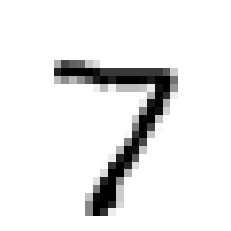

In [0]:
X_sample = Xtest1[0:1, :, :, :]
plt.imshow(X_sample[0, 0, :, :].detach().cpu(), cmap='binary')
plt.axis('off')

Now showing the output of first convolutional neural network

output  of first convolutional layer


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:178: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


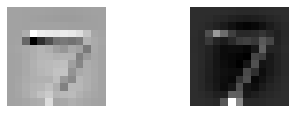

In [0]:
print('output  of first convolutional layer')
show_layer_output(nnet, X_sample, 0);


So as the first convolutional layer has 2 units  it  shows 2 ouputs. 


The first unit applies the kernel on the input image.


The second unit applies the kernel on the input image 

Now showing the output of the second convolutional layer.

output  of second convolutional layer


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:178: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


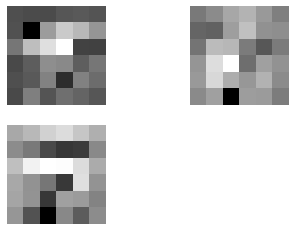

In [0]:
print('output  of second convolutional layer')
show_layer_output(nnet, X_sample, 1);


So the same thing as the second convolutional layer has 3 units it shows 3 outputs and the logic is same as the first one. Output of one layer  becomes the input of the other layer.

Now showing the weights of the first layer

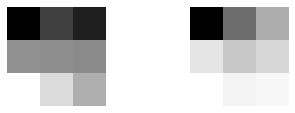

In [0]:

show_layer_weights(nnet, 0);

So the weights from the first unit of the first convolutional layer is used to convolve the image and as a  result a lighter image is produced with a darer shade at the top corner according to the weights . And when that result is taken as input byu the second unit it applies its own weight and due to the presence of a black pixel it also produces a more dark black type thing.

Showing the weights of the second layer

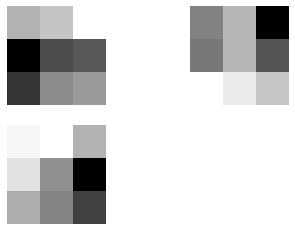

In [0]:
show_layer_weights(nnet, 1);

Extra Credit 2

First with gpu=False

In [0]:
nnet = NeuralNetwork_Convolutional(n_channels_in_image=1,
                                   image_size=28,
                                   n_units_in_conv_layers=[5],
                                   kernels_size_and_stride=[[3,2]],# , 5],
                                   n_units_in_fc_hidden_layers=[2], # 10, 10],
                                   classes=P,
                                   use_gpu=False)

Xtrain1=make_images1(25000,Xtrain)

Xtrain1=torch.tensor(Xtrain1)
Xtrain1=Xtrain1.float()
nnet.train(Xtrain1, Ttrain, 200, learning_rate=0.01)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:137: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch 0 error 2.3856313228607178
Epoch 10 error 1.968096137046814
Epoch 20 error 1.8511104583740234
Epoch 30 error 1.7621294260025024
Epoch 40 error 1.6827312707901
Epoch 50 error 1.610481858253479
Epoch 60 error 1.5470079183578491
Epoch 70 error 1.4921107292175293
Epoch 80 error 1.4486924409866333
Epoch 90 error 1.4089754819869995
Epoch 100 error 1.3777592182159424
Epoch 110 error 1.3500617742538452
Epoch 120 error 1.328441858291626
Epoch 130 error 1.3077043294906616
Epoch 140 error 1.2894625663757324
Epoch 150 error 1.2748444080352783
Epoch 160 error 1.2626150846481323
Epoch 170 error 1.2525144815444946
Epoch 180 error 1.2446321249008179
Epoch 190 error 1.232884407043457


Training time for gpu=false

In [0]:
print(f'  Training took {nnet.training_time:.3f} seconds.')

  Training took 350.909 seconds.


Nw with gpu=true

In [0]:
nnet = NeuralNetwork_Convolutional(n_channels_in_image=1,
                                   image_size=28,
                                   n_units_in_conv_layers=[5],
                                   kernels_size_and_stride=[[3,2]],# , 5],
                                   n_units_in_fc_hidden_layers=[2], # 10, 10],
                                   classes=P,
                                   use_gpu=True)

Xtrain1=make_images1(25000,Xtrain)

Xtrain1=torch.tensor(Xtrain1).to('cuda')
Xtrain1=Xtrain1.float()
nnet.train(Xtrain1, Ttrain, 200, learning_rate=0.01)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:137: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch 0 error 2.3590621948242188
Epoch 10 error 1.9480531215667725
Epoch 20 error 1.815647840499878
Epoch 30 error 1.7194641828536987
Epoch 40 error 1.6438478231430054
Epoch 50 error 1.5867663621902466
Epoch 60 error 1.5411614179611206
Epoch 70 error 1.5029754638671875
Epoch 80 error 1.4691754579544067
Epoch 90 error 1.4380563497543335
Epoch 100 error 1.408936858177185
Epoch 110 error 1.3811194896697998
Epoch 120 error 1.3546298742294312
Epoch 130 error 1.3296074867248535
Epoch 140 error 1.3065170049667358
Epoch 150 error 1.2857012748718262
Epoch 160 error 1.2673454284667969
Epoch 170 error 1.2621870040893555
Epoch 180 error 1.24311363697052
Epoch 190 error 1.230446457862854


Time for GPU=true

In [0]:
print(f'  Training took {nnet.training_time:.3f} seconds.')

  Training took 22.598 seconds.


So we can see that without gpu traning time is 350.909 sec while that with gpu is 22.598 sec. So there is a huge time difference. This is due to the fact that gpu can make several computations in a parallel manner due to presence of huge number of cores in GPU while the cpu cannot. 


Again if the dataset size is very small  the result will be reversed as the tme of taking the values from gpu to cpu is going to be affecting the runtime.